In [1]:
!pip install mip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.8/441.8 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: cffi
    Found existing installation: cffi 1.16.0
    Uninstalling cffi-1.16.0:
      Successfully uninstalled cffi-1.16.0


Custo da rota:       165.06
Rota: 
  0  18  13  11  16  19   9   2   1  10  15   8  20  12  17   3  14   4   7   5   6 



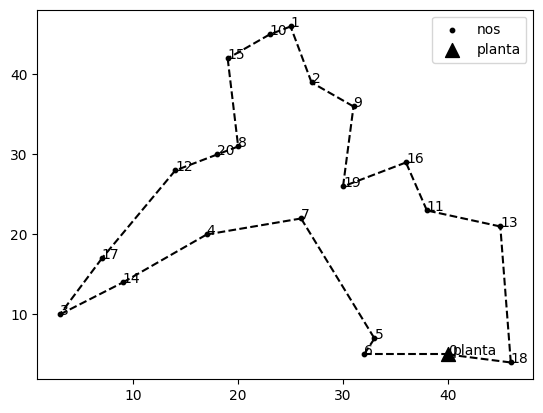

In [5]:
from mip import Model, xsum, minimize, CBC, OptimizationStatus, BINARY
from itertools import product
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

n = 21
planta = 0

N = range(n)
A = [(i,j) for (i,j) in product(N,N) if i != j]

# posicao geografica dos nos
posx = np.array([40, 25, 27, 3, 17, 33, 32, 26, 20, 31, 23, 38, 14, 45, 9, 19, 36, 7, 46, 30, 18])
posy = np.array([5, 46, 39, 10, 20, 7, 5, 22, 31, 36, 45, 23, 28, 21, 14, 42, 29, 17, 4, 26, 30])




c = [ [ sqrt( (posx[i] - posx[j])**2 + (posy[i] - posy[j])**2 ) for j in N ] for i in N]

model = Model('Problema do caixeiro viajante',solver_name=CBC)

x = {(i,j) : model.add_var(var_type=BINARY) for (i,j) in A}
f = {(i,j) : model.add_var(lb=0.0) for (i,j) in A}

model.objective = minimize(xsum(c[i][j] * x[i,j] for (i,j) in A))

for i in N:
    model += xsum(x[ii,j] for (ii,j) in A if i == ii) == 1
    for j in N:
        model += xsum(x[i,jj] for (i,jj) in A if j == jj) == 1

model += xsum(f[i,j] for (i,j) in A if i == planta) == n - 1

for j in N:
    if j != planta:
        model += xsum(f[i,jj] for (i,jj) in A if j == jj) == 1 + xsum(f[jj,i] for (jj,i) in A if j == jj)

for (i,j) in A:
    model += f[i,j] <= (n-1) * x[i,j]

status = model.optimize()
if status == OptimizationStatus.OPTIMAL:
    print("Custo da rota: {:12.2f}".format(sum([c[i][j] * x[i,j].x for (i,j) in A])))
    cur_no = planta
    print("Rota: ")
    while True:
        print("{:3d} ".format(cur_no),end='')
        cur_no = [j for (i,j) in A if i == cur_no and x[i,j].x > 0.9][0]
        if cur_no == planta:
            break;
    print(), print()

fig, ax = plt.subplots()
plt.scatter(posx[:],posy[:],marker="o",color='black',s=10,label="nos")
for i in N:
    plt.text(posx[i],posy[i], "{:d}".format(i))

for (i, j) in [(i, j) for (i, j) in A if x[i, j].x >= .9]:
    plt.plot((posx[i], posx[j]), (posy[i], posy[j]), linestyle="--", color="black")

plt.scatter(posx[0],posy[0],marker="^",color='black',s=100,label="planta")
plt.text(posx[0]+.5,posy[0], "{:s}".format("planta"))
plt.legend()
plt.plot()
plt.savefig("exemplo_solucao.pdf")
plt.show()